# Prediction of Credit Card Default Using Multiple Techniques

## Project Context

The UCI Machine Learning Repository is a popular archive of datasets available for academic analysis of machine learning and analytical techniques (Dua & Graff, 2019). As it is used by students and researchers world-wide, information on its datasets offers potential for high impact on the work of data analysts. For one of its datasets, “default of credit card clients,” an accompanying paper compares the performance of various data mining techniques in predicting credit default (Yeh & Lien, 2009).

This paper however does not divulge many of its key methodologies—for example:  data preparation, model tuning, and justification of features used. Of particular note, the paper seems to retain all 23 dataset features as model predictors for each data mining technique utilized. In constrast, I propose that a model, with performance greater than chance guessing, may be developed for each of the data mining techniques discussed in the paper, but using only a subset of the features found within the dataset.

By requiring less features such models offer the potential for greater interpretability and decreased computational loads. Furthermore, by detailing the methodologies used, this provides an opportunity to demonstrate effective model building across various data mining techniques. For this task, I use SciKit-Learn's algorithm sets and accuracy, sensitivity, and ROC AUC scores to evaluate the models.

**To summarize, the question here addressed is**: *Can credit card default be predicted using only a subset of the features retained in the work of Yeh and Lien (2009)?*

## Table of Contents

* [Notebook Setup](#Notebook-Setup)
* [Data Cleaning](#Data-Cleaning)
* [Data Exploration and Feature Selection](#Data-Exploration-and-Feature-Selection)
* [Data Preparation](#Data-Preparation)
* [Model Building](#Model-Building)
 * [General Methodology](#General-Methodology)
 * [Model Evaluation](#Model-Evaluation)
 * [Random Forest](#Random-Forest)
 * [KNN](#KNN)
 * [Naive Bayesian](#Naive-Bayesian)
 * [Discriminant Analysis](#Discriminant-Analysis)
 * [Neural Net](#Neural-Net)
 * [Logistic Regression](#Logistic-Regression)
 * [Chance Simulation](#Chance-Simulation)
* [Final Model Comparisons](#Final-Model-Comparisons)
* [References](#References)


## Notebook Setup

First we import the necessary libaries used in the project.

In [105]:
# For general data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Setting the default visualization style to that of Seaborn's parameters
sb.set()
# Allow the Pandas dataframe displays to show more columns that normal since this is a wide set
pd.set_option('display.max_columns', 50)

# A number of tools for data preparation, model building, and model performance
from sklearn.preprocessing import StandardScaler # for standardizing data
from sklearn.model_selection import train_test_split, GridSearchCV # tools used in model building
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix # for evaluating models

# The various algorithms used in this project
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

Next we import our data to a Pandas dataframe.

In [3]:
# Load our dataset
df = pd.read_csv('credit_card_defaults.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Data Cleaning

Before we get started with our model building, we should explore the overall quality of the data. First let's do a general survey of the data-set.

In [4]:
# Print meta information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

Looking at the general dataframe information, most seems in order at face-value. There doesn't appear to be any missing values and, as expected from the dataset's accompanying information, all values are either numerical or categorical-numerical encoded.

Initially it appears that a variable `PAY_1` might be missing when looking at the names, but the dataset description only lists 6 variables in this set which is in accordance with what we see here.

We should still explore the dataset in more detail however. Before we do so, let's establish a cleaned copy along with some convenience references to the columns. Let's also rename the target variable to be shorter and with consistent case.

In [5]:
# Create a cleaned dataset copy to work on
dfc = df.copy()

# Rename the target column to be shorter and with more consistent case
dfc.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)

# Create a list of all variables excluding the ID column
all_vars = list(dfc)
all_vars.remove('ID')

# And a list of all the features (with the target column removed)
all_features = list(all_vars) # list call to create a new copy
all_features.remove('DEFAULT')

Now let's use `describe` to get a broad picture of the data. Since all of our categorical data is already numerically encoded, this will capture all of our features.

In [6]:
# Print general distribution stats for all variables
dfc[all_vars].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


There are a few noticeable cleaning concerns we might notice from above:
* `SEX` is encoded as 1 or 2. To make it more consistent with typical one-hot encodings, we might want to recode as 0 or 1.
* `EDUCATION` has a min of 0 and max of 6, whereas the dataset description only accounts for ordinal encoding of 1 to 4.
* `MARRIAGE` has a min of 0, whereas the dataset descripton only accounts for ordinal encoding 1 to 3. As the categories are "married", "single", and "others", this also makes more sense as a nominal encoding.
* The "PAY_..." columns have a min of -2, whereas the dataset description only accounts for ordinal encoding -1 to 8, skipping 0. Since 0 is not included, we should also check that here.
* Some of the Bill Amounts are particularly high, in both positive and negative directions. This may be accurate, but it's worth doing a quick check if high values are present enough to not likely be aberrant.
* The mean of `DEFAULT` is small and thus tells us there is a low relative frequency of the target in the dataset. At about ~20%, it does not appear small enough to require oversampling techniques. In the least, given the diversity of models used here, and the many possible corrections that might be needed for such, oversampling is not addressed in this exercise.
* We should also do a general duplicates check.

**Checking for duplicates**

Let's first do a check using all of the columns.

In [7]:
# Duplicate tally including all columns (inclusive of the ID column)
dfc.duplicated().sum()

0

And let's also do a duplicate check ignoring the ID column (i.e. assuming an observation was erroneously given a new ID).

In [8]:
# Printing a count of duplicates based
dfc.duplicated(subset=all_vars).sum()

35

Noting the above, there are no obvious duplicates, but is possible some duplicates exist that were erroneously given new IDs. Given that the variables in this dataset (such as age and sex) could be shared amongst multiple individuals, each also potentially having the same payment patterns, it's difficult to conclude these are true duplicates without access to more identifying variables like names. Considering this, as well as the small number compared to the dataset size, we choose to retain these observations here.

**Re-encoding the `SEX` variable**

Encoded to 1/"male" = 0, 2/"female" = 1.

In [9]:
# Re-encode the SEX variable as noted above
dfc.SEX.replace({1:0, 2:1}, inplace=True)

**Cleaning the `MARRIAGE` variable**

We noted earlier some unexpected values of 0. Let's first see how many.

In [10]:
# Print number of MARRIAGE values = 0
(dfc.MARRIAGE == 0).sum()

54

Since there's not many of these 0 values and "others" are already encoded as 3, we can consider simply collapsing those into the same category (encoding them as 3).

It's a good habbit to do a quick check that these other values don't differ greatly with the response before doing so though. This isn't really necessary here, but it's performed as a reminder.

In [11]:
# Find the relative frequencies of the target compared to each level of MARRIAGE
for level in [0,1,2,3]:
    
    # Run our calculations
    lvl_count = len(dfc.query('MARRIAGE == @level')) # The @ forces the interpreter to read the variable
    freq_count = len(dfc.query('MARRIAGE == @level and DEFAULT == 1'))
    rel_freq = freq_count / lvl_count
    
    # Print the results
    print("Relative default freq for level {} is {}".format(level, rel_freq))

Relative default freq for level 0 is 0.09259259259259259
Relative default freq for level 1 is 0.23471703638626545
Relative default freq for level 2 is 0.20928338762214985
Relative default freq for level 3 is 0.26006191950464397


Were there more instances relative to the size of the dataset, we might consider not collapsing the levels (0 and 3) given the different variance with the response seen above. However, in this case it is sensible.

In [12]:
# Move the unexpected 0 values of MARRIAGE into the other (3) level
dfc.MARRIAGE.replace({0:3}, inplace=True)

Given that `MARRIAGE` has an "other" category and no obvious ranking, we have little reason to leave this as ordinal encoding. Instead let's use one-hot encoding to treat this as a nominal variable. Since many model algorithms require dropping one level (which becomes the reference level), we'll go ahead and drop the first level "married." **Our refernce level is then "married" with "single" and "others" retained.** While this might disadvantage decision tree models, the added cardinality is low here and unlikely particularly disadvantageous.

In [13]:
# Create dummy variables for the MARRIAGE levels, dropping the reference level
dfc[['MARRIAGE_SINGLE', 'MARRIAGE_OTHERS']] = pd.get_dummies(data=dfc.MARRIAGE, drop_first=True)
# Drop the old MARRIAGE column
dfc.drop(columns=['MARRIAGE'], inplace=True)

# Check that it worked
dfc.head(1)

,ID,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,MARRIAGE_SINGLE,MARRIAGE_OTHERS
0,1,20000,1,2,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0


Let's clean up our variable list since we changed what's in the dataset.

In [14]:
# For both of our convenience lists, remove MARRIAGE but add the dummie vars
all_vars.remove('MARRIAGE')
all_vars.extend(['MARRIAGE_SINGLE', 'MARRIAGE_OTHERS'])

all_features.remove('MARRIAGE')
all_features.extend(['MARRIAGE_SINGLE', 'MARRIAGE_OTHERS'])

In [15]:
# Let's also move DEFAULT to the end of the list for organization later
all_vars.append( all_vars.pop(all_vars.index('DEFAULT')) )

**Cleaning the `EDUCATION` variable**

We saw earlier that there was unexpected `EDUCATION` levels of 0, 5, and 6. Let's first see how many of those there are.

In [16]:
# Show the counts of each of the unexpected levels
(dfc.EDUCATION == 0).sum(), (dfc.EDUCATION == 5).sum(), (dfc.EDUCATION == 6).sum()

(14, 280, 51)

Which we might consider moving to the "others" level (4). So how many are in that level?

In [17]:
(dfc.EDUCATION == 4).sum()

123

There's not too many of these, or those of the "others" category compared to the overall dataset. Again though it's not a bad habbit to see if any level greatly differs in relative frequency with the target.

In [18]:
# Find the relative frequencies of the target compared to each level of EDUCATION
for level in [0,1,2,3,4,5,6]:
    
    # Run our calculations
    lvl_count = len(dfc.query('EDUCATION == @level')) # The @ forces the interpreter to read the variable
    freq_count = len(dfc.query('EDUCATION == @level and DEFAULT == 1'))
    rel_freq = freq_count / lvl_count
    
    # Print the results
    print("Relative default freq for level {} is {}".format(level, rel_freq))

Relative default freq for level 0 is 0.0
Relative default freq for level 1 is 0.19234766178554558
Relative default freq for level 2 is 0.23734853884533144
Relative default freq for level 3 is 0.2515761643278422
Relative default freq for level 4 is 0.056910569105691054
Relative default freq for level 5 is 0.06428571428571428
Relative default freq for level 6 is 0.1568627450980392


Level 0 has no target values (credit defaults), but is so low in frequency that this could just be due to chance given the already low proportion of the target in the dataset. While Level 5 is represented by a couple hundred instances, it could sensibly be fit into our "others" level (4) here give its proportion. Level 6 seems a bit off, but is only a small portion of the overall dataset, and we have little additional information to work with. As such, let's go ahead and make the move of the values to Level 4.

In [19]:
# Move the unexpected EDUCATION values into the "others" level
dfc.EDUCATION.replace({0:4, 5:4, 6:4}, inplace=True)

As there is a clear order of decreasing education from "graduate school" (1) to "high school" (3), with the exception of "other" (4), it's reasonable to keep this as ordinal encoded to keep our cardinality down here.

However, if we are ordinal-encoding, we may note that the position of "other" is currently arbitrary and logically could just as easily be defined on either end of the ordinality scale. However, if we flipped it to the other end, we may be able to extract more predictive power as this creates an observed pattern of increasing relative frequency of the target.

That considered, let's do one more encoding on the education column and re-encode "others" as 0.

In [20]:
# Move the "others" level to the other pole of the ordinality
dfc.EDUCATION.replace({4:0}, inplace=True)

**Unexpected "PAY_#" column values**

We saw earlier that there were unexpected values of -2 in the "PAY_#" columns, as well as the possibility for unexpected values of 0. Let's first see just how many of such values are present.

First let's get a count of the number of times we see the -2 value.

In [21]:
# Create a list of the columns we're working with
payvar_list = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
# Create an empty list to append counts of the unexpected values to
payvar_negtwo_count = []
payvar_zero_count = []

# Loop through each of the variables at hand
for var in payvar_list:
    
    # Append the matching counts to respective lists
    payvar_negtwo_count.append((dfc[var] == -2).sum())
    payvar_zero_count.append((dfc[var] == 0).sum())

# Print the summed results
print("There are {} instances of -2".format( np.sum(payvar_negtwo_count )))
print("There are {} instances of 0".format( np.sum(payvar_zero_count )))

There are 24415 instances of -2
There are 95919 instances of 0


Given then counts above, there are far too many values of each unexpected case for us to presume them aberrant. It's likely these values then are in fact meaningful, but the documentation simply didn't include the meaning of their encoding. As such, we should leave the values in the cleaned dataset as-is.

**Deleting the old dataframe**. Since we no longer need it as a backup.

In [22]:
del df

## Data Exploration and Feature Selection

Since we have a considerable number of possible features to discriminate against, it's easier to review correlation coefficients to assist in features selection.

We have a number of different variable types here however-- binary, ordinal, and continuous-- and we know little about their underlying distributions. As such, we should be careful in our application.

The possible combinations to consider are as follows:
* **Continuous-Binary** - We can use use Pearson's r, which in this case becomes synonymous with the point-biserial coefficient.
* **Continous-Ordinal** - Here we can use Spearman's rho correlation coefficient since it evaluates ranks.
* **Ordinal-Ordinal** - Since these can be considered as ranks, we can again use Spearman's rho.
* **Continuous-Continuous** - While Pearon's r captures linear correlations, a relationship could be monotonic but non-linear. As such we should also review Spearman's rho for this pairing.
* **Binary-Binary** - Here we would desire the phi coefficient. This however is synonymous with Pearson's r applied to two dichotomous variables.
* **Binary-Ordinal** - While this is technically a comparison of a nominal and ordinal variable, the most important case observered here is that of our binary response with ordinal predictors (namely `EDUCATION` here). Since our response is binary and we hold a particular interest in one of the classes, we might reasonably consider it as ordinal. That considered, Kendall's tau is a reasonable metric as it performs based on the proportion of ranks within the sets. Other, perhaps more appropriate, metrics exists; however, this metric is provided in the libraries used here and fine for this level of exploration.

Given the above considerations, we can use Pearson's r, Spearman's rho, and Kendall's tau to account for the key pairings in our dataset. This will also allow for a general snapshot of possible issues of collinearity that might arise in models such as logistic regression.

Conveniently Pandas provides the `.corr()` method which provides a correlation matrix for each of the above coefficient types (produced below).

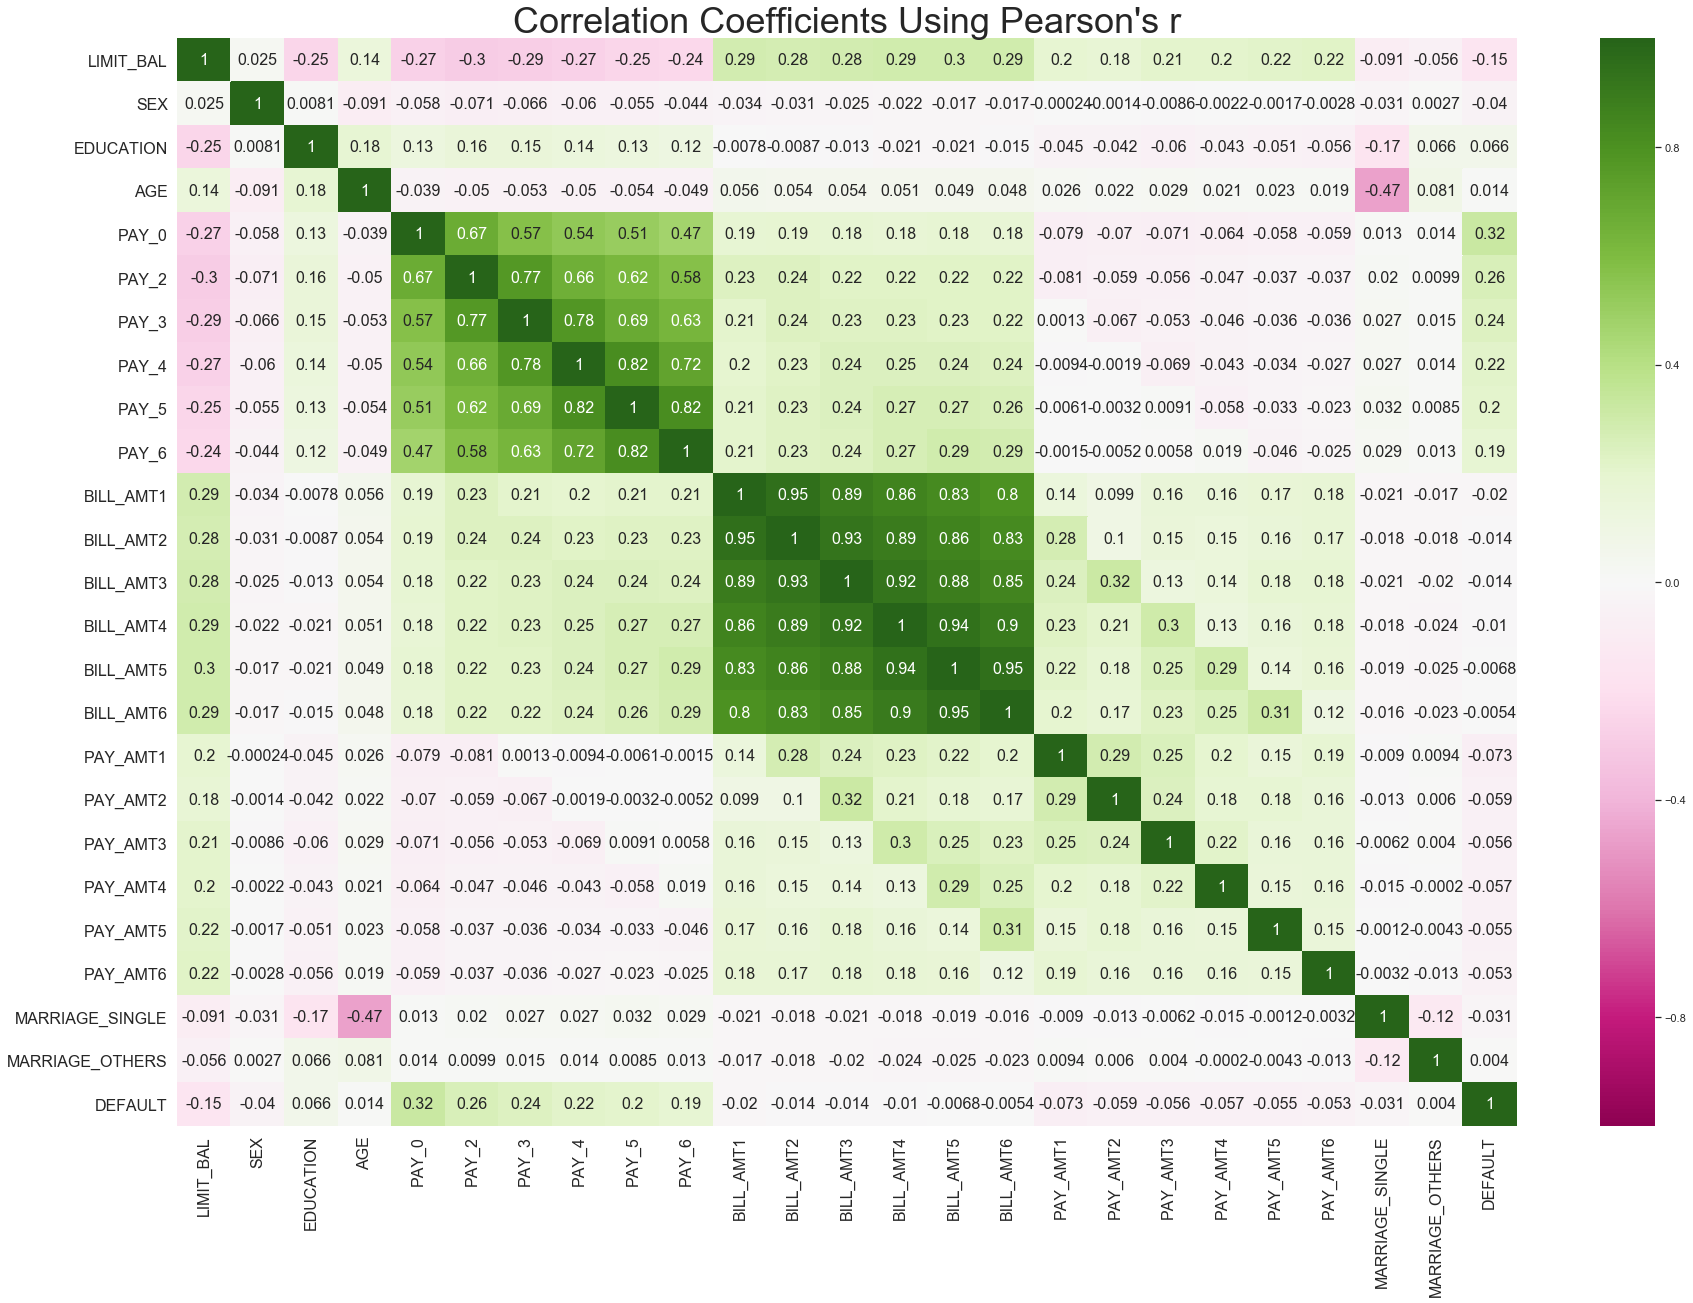

In [23]:
# Pearson's r correlation map
plt.figure(figsize=(30,20))
sb.heatmap(dfc[all_vars].corr(method='pearson'), cmap='PiYG', annot=True, vmin=-1, vmax=1, annot_kws={"size":16})
plt.yticks(size=16)
plt.xticks(size=16)
plt.title("Correlation Coefficients Using Pearson's r", size=36)
plt.show()

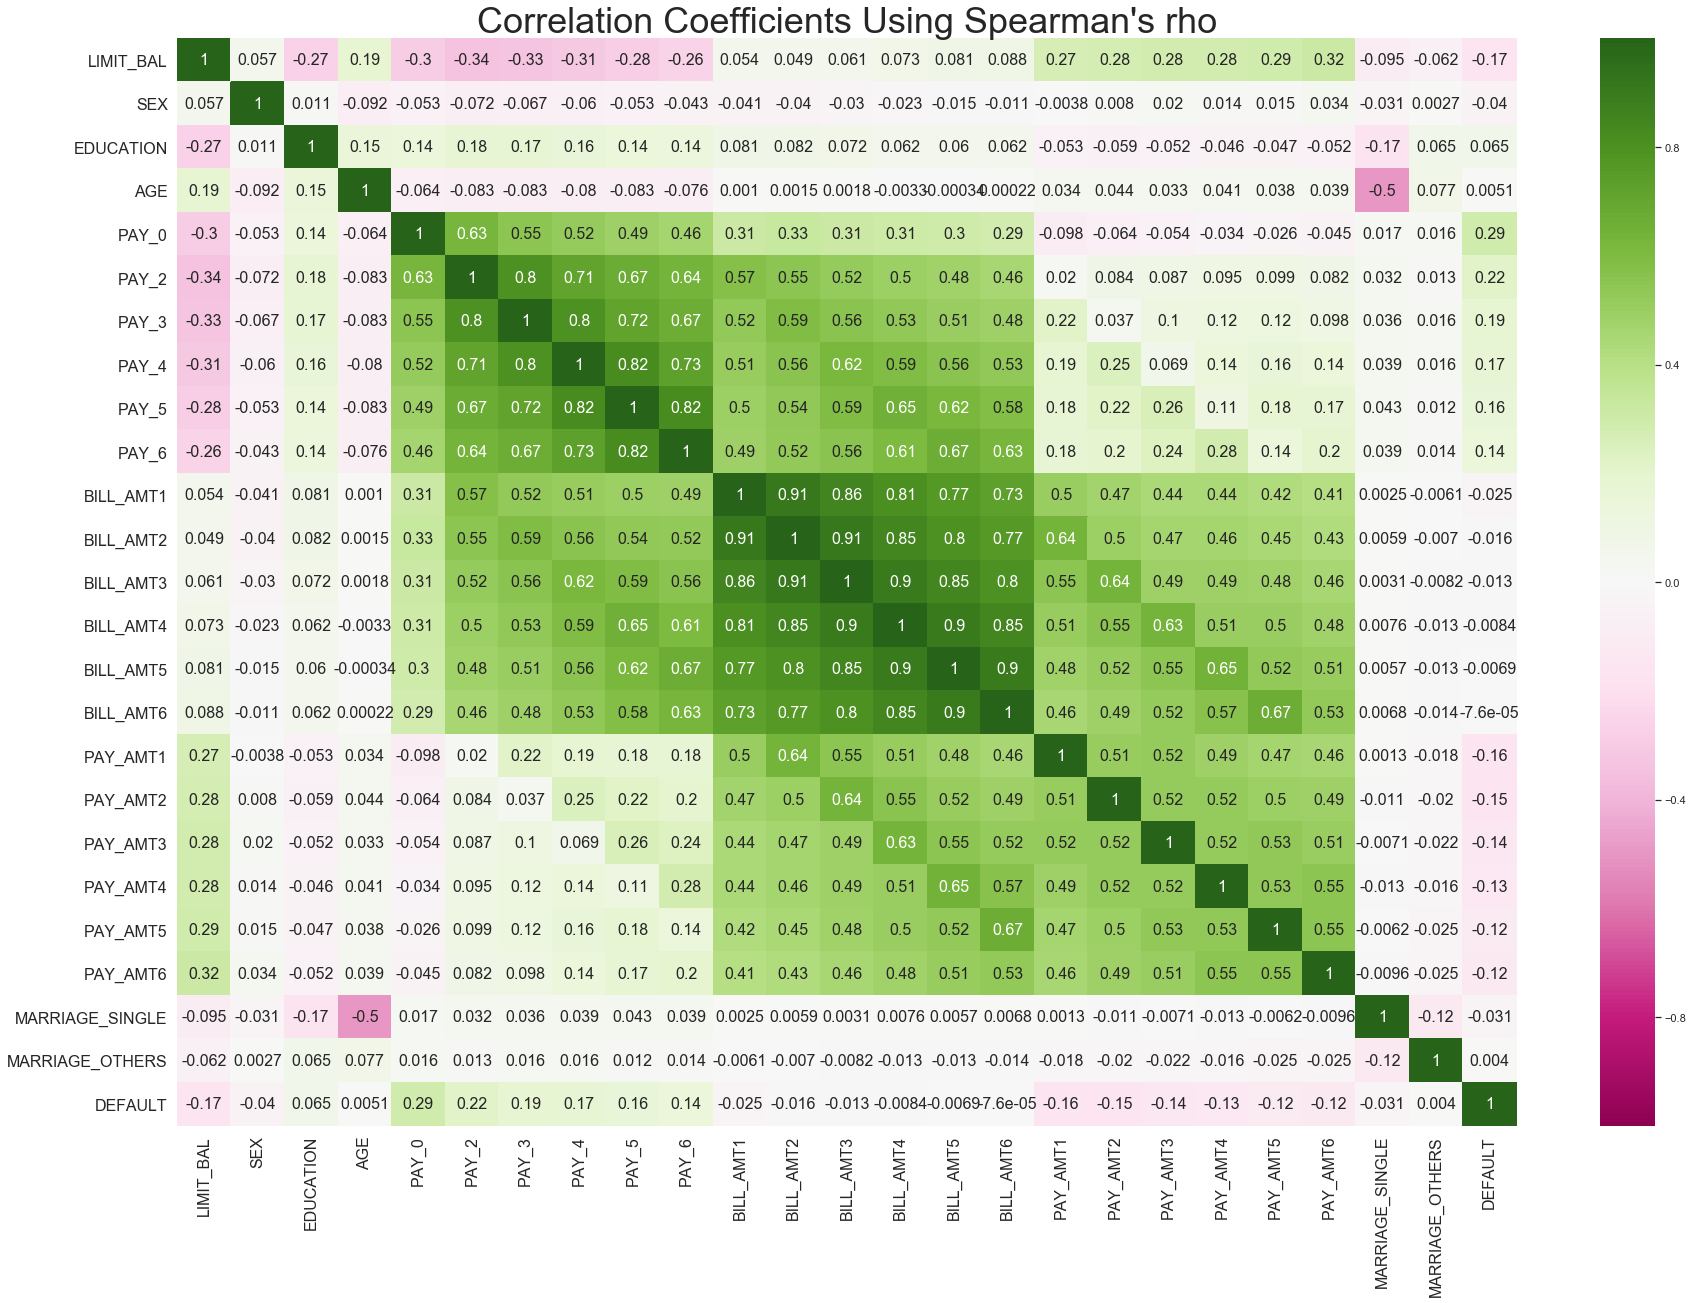

In [24]:
# Spearman's rho correlation map
plt.figure(figsize=(30,20))
sb.heatmap(dfc[all_vars].corr(method='spearman'), cmap='PiYG', annot=True, vmin=-1, vmax=1, annot_kws={"size":16})
plt.yticks(size=16)
plt.xticks(size=16)
plt.title("Correlation Coefficients Using Spearman's rho", size=36)
plt.show()

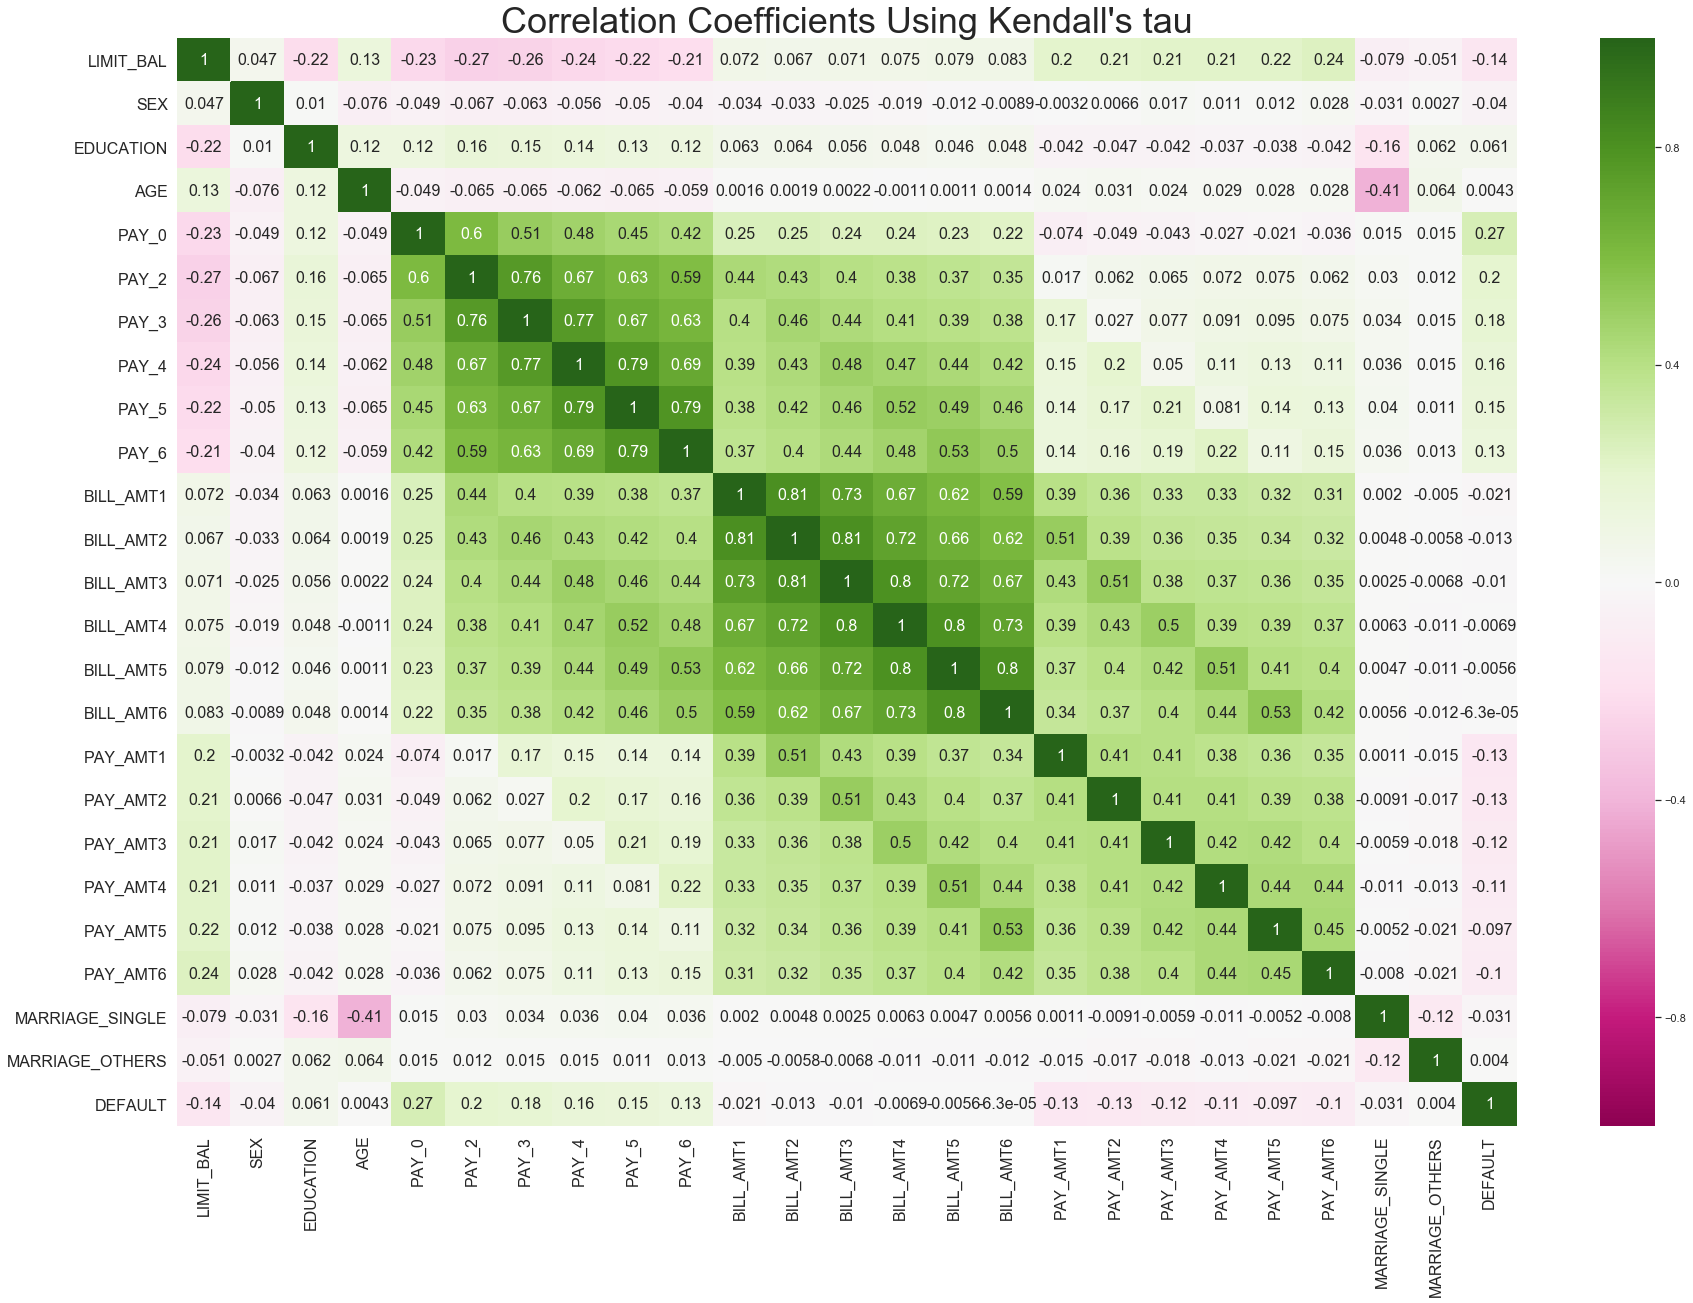

In [25]:
# Kendall's tau correlation map
plt.figure(figsize=(30,20))
sb.heatmap(dfc[all_vars].corr(method='kendall'), cmap='PiYG', annot=True, vmin=-1, vmax=1, annot_kws={"size":16})
plt.yticks(size=16)
plt.xticks(size=16)
plt.title("Correlation Coefficients Using Kendall's tau", size=36)
plt.show()

Even when comparing all correlation coefficient metrics, we can see that only the following predictors have coefficients (c) such that |c| > 0.1:
* `LIMIT_BAL`
* All "Pay_#" columns
* All "PAY_AMT#" columns

This strength of coefficients is quite consistent across all measures with very few other cases coming close to a value of 0.1 with the exception of the "PAY_AMT#" columns under Pearson's r. Since Pearson's r evaluates linear relationships and Spearman's allows for monotonic ones, it may be that the probability of the response increases monotonically with this variable set, but not linearily. We then would reasonably choose to keep them in with our evaluation.

While the cutoff of 0.1 is arbitrary, the correlation coefficient distribution observed provides good reason to believe that such a cutoff captures much of the variance in the target giving the clear pattern from the maps above.

Another consideration observed from the above correlation matrices is considerable correlation amongst the predictors, specifically those we might consider as prime correlates with the target. As the goal of our work here is prediction and relative dimension reduction, rather than explanatory value, we will not address correlation amongst the predictors directly (for instance by PCA or further removal of variables). We should, however, keep this concern in mind for any models used that are affected by collinearity, such as logistic regression. For logistic regression then we might consider using regularization techniques in our approach.

Ultimately we can now reasonably move forward using the identified features above as our reduced feature set for model building.

In [26]:
# Variable for our determined subset of predictive features
subset_features = ['LIMIT_BAL',
                   'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

## Data Preparation

In order to build our models, we will want to split our data into train and test sets. Some of the models used here also require the data to be standardized. Finally, it would be useful to consider model strength when using the full set of features compared to that of the subset.

As such, we create train and test sets with multiple variants-- using all features (denoted with `a`) or the subset of features (denoted with `b`), as well as standardized versions (denoted with `_s_`).

First we create our train-test splits.

In [27]:
# Define our feature and target sets
Xa = dfc[all_features] # Matrix using all features
Xb = dfc[subset_features] # Matrix using the determined subset of features
y= dfc['DEFAULT']

# Split into training and test sets
# For all features
Xa_train, Xa_test, y_train, y_test = train_test_split(Xa, y, test_size=0.2, stratify=y, random_state=42)
# For the subset of features
Xb_train, Xb_test, y_train, y_test = train_test_split(Xb, y, test_size=0.2, stratify=y, random_state=42)

# Double check the shape to check the results
print(Xa_train.shape, y_train.shape)
print(Xb_train.shape, y_train.shape)
print(Xa_test.shape, y_test.shape)
print(Xb_test.shape, y_test.shape)

(24000, 24) (24000,)
(24000, 13) (24000,)
(6000, 24) (6000,)
(6000, 13) (6000,)


Next we create our standardized versions of each train-test split. As would be appropriate to a real-world setting, the scalers used must be fit to the training data and then applied to both the training and test data when transformed.

In [28]:
# Create our scalers off of the training data
sc_a = StandardScaler().fit(Xa_train)
sc_b = StandardScaler().fit(Xb_train)

# Create standardized versions of each of our sets
Xa_s_train = sc_a.transform(Xa_train)
Xa_s_test = sc_a.transform(Xa_test)
Xb_s_train = sc_b.transform(Xb_train)
Xb_s_test = sc_b.transform(Xb_test)

Models will be built on train-test splits for both all features, and for the subset of features. However, models will only used standardized versions if the model algorithm benefits from that approach.

## Model Building

### General Methodology


We use SciKitLearn for our model building due to its richness of machine learning methodologies and ability to perform all of the relevant techniques of interest.

The general methodology for each model build follows:
1. Define a parameter space representing different possible sets of parameters to use with the model.
2. Run an exhaustive grid search with cross validation of the parameter space to retrieve scores (accuracy, recall, ROC-AUC) for each parameter set.
3. Evaluate and select the top-scoring parameter set (typically by ROC-AUC).
4. Refit the model using the determined best parameter set and then evaluate its scores against the test data set.

While accuracy will be considered in model evaluation, it can not act as the primary arbitrater of performance. In this case, this is due to the fact that the target level makes up only ~20% of the response. As such, simply labelling all test values with 0 would have an accuracy of ~80%. For this reason we also consider recall, which measures the proportion of actual positives identified, and ROC AUC which seeks to balance this against the false positive rate.

For each model case below we then only discuss the parameter space chosen and any information needed in determining the optimal set.

Overall, we evaluate the following model types below:
* Classification Trees (Random Forest)
* KNN
* Neural Net
* Discriminant Analysis
* Naive Bayesian
* SVC
* Logistic Regression

### Model Evaluation

For evaluating the performance of each model, we define the following helper function. This function takes model meta information and fit data on the test set to provide the following:

* Create a confusion matrix for the model
* Calculate accuracy, recall/sensitivity, and ROC AUC scores
* Print the results for view in the notebook
* Store the model performance scores in a csv file for later use

Ultimately the csv file will be used at the end of this notebook to compare model performance.

In [29]:
# Create helper function for model evaluation
def model_report(model, feature_set, params, predicted_classes, predicted_probs, actual_classes):
    
    # Create a simple confusion matrix using SciKitLearn's implementation
    cfn_matrix = confusion_matrix(y_true=actual_classes, y_pred=predicted_classes)

    # Convert to pandas dataframes for easier visualization
    cfn_df = pd.DataFrame(cfn_matrix, index=['Actual Negative', 'Actual Positive'],
                                 columns=['Predicted Negative', 'Predicted Positive'])

    # Calculate overall accuracy and sensitivity
    accuracy = cfn_matrix.diagonal().sum() / cfn_matrix.sum().sum() # Sum twice to get both axis
    # Calculate sensitivity
    sensitivity = cfn_df.loc['Actual Positive', 'Predicted Positive'] / cfn_df.loc['Actual Positive'].sum()
    # Calculate AUC score
    auc_score = roc_auc_score(y_true=actual_classes, y_score=predicted_probs)
    
    # Create a dataframe used to store to csv
    report_df = pd.DataFrame(data={'Score': [accuracy, sensitivity, auc_score],
                                   'Score_Type': ['accuracy', 'recall', 'roc auc'],
                                   'Model': [model]*3,
                                   'Feature_Set': [feature_set]*3,
                                   'Parameters':[params]*3})
    
    # Append the results to a csv file (creat the file if it doesn't exist)
    with open('score_report.csv', 'a+', newline='\n') as f: # Change the newline setting so it doesn't add blanklines
        report_df.to_csv(f, mode='a', header=(f.tell()==0), index=False) # f.tell() notes whether at the start of file
    
    # Print results in our notebook
    print("For the {} model on feature set {}:".format(model, feature_set))
    print("\n")
    print("Accuracy is {}".format(accuracy))
    print("Sensitivity is {}".format(sensitivity))
    print("AUC score is {}".format(auc_score))
    print("\n")
    print(cfn_df)

### Random Forest

#### Parameter Space Considerations

Randdom forest algorithms have a number of possible paraemters that can be tuned, so an exhaustive grid search of the parameter space, without carefully choosing the parameters we really care about, can lead to long computation times with minimal added value in terms of model performance.

To reduce the dimensionality of our parameter space, we may first notice that, according to the documentation of the algorithm used here, the main parameters we should consider are the number of trees (`n_estimators`) and the max number of features available to each tree (`max_features`). More specifically, empirically good fits are often found using a large `n_estimators` and the square root of the total number of features for `max_features` (for classifiers). The documentation also reccomends the trees be allowed to fully grow (`max_depth = None`), and the minimum number of samples needed to make a split (`min_samples_split`) is 2 ("Ensemble methods — scikit-learn 0.22.1 documentation", 2020).

A literature review of common random forest default parameters (Probst et al., 2019) generally agrees with the considerations above and the default parameters of SciKit-Learn's classifier ("Sklearn.ensemble.RandomForestClassifier — scikit-learn 0.22.1 documentation", 2020); however it does make a few more noteworthy observations for use in this case:
* Common number of trees: 500, 1000
* Additional tuning, both above and below the square root of features, should be done for `max_features`
* Common criterion for split defaults are "gini", "p-value", and "random"

Regarding the number of trees, research supports that tuning this parameter is not reccomended. We might hope to search for the point at which additional trees only provide diminsihing returns, but otherwise providing 500 or 1000 trees is generally enough to achieve much of the performance possible (Probst et al., 2017). 500 is chosen here due to computational load.

For tuning `max_features`, we can make an arbitrary decision to expand the parameter space two step above and below the the square root of the features. We do so below, creating our spacing by using floor division of the square root of the features as a midpoint.

In [138]:
# Create a function since we need to do this for both feature-spaces
def val_space(list):
    length = len(list)
    midpoint = int(round(length ** 0.5, 0)) # "midpoint" is the square root of the number of features
    step_up = (length - midpoint) // 3
    step_down = midpoint // 3
    vals_up = [midpoint + step_up, midpoint + (2 * step_up)]
    vals_down = [midpoint - (2 * step_down), midpoint - step_down]
    vals = vals_down + [midpoint] + vals_up
    return vals

# Store these values for use later
max_features_subset = val_space(subset_features)
max_features_allfeat = val_space(all_features)

# Print to double check
print(max_features_subset, max_features_allfeat)

[2, 3, 4, 7, 10] [3, 4, 5, 11, 17]


Unfortunately for the other consideration, Scitkit-learn only offers `gini` and `entropy` as split criterion types, so we're stuck with using `gini"` here.

Other research also suggests the importance of tuning either tree subsample size or depth, and that tuning either is generally sufficient instead of both (Scornet, 2017). Since tree depth can be controlled by `min_samples_split` as a fraction of the number of samples, the following settings are used here: of 2 (the default), 1% of samples, and 5% of samples. If higher performance were shown at 5% of samples, we could re-run the model to consider higher fractions.

The overall parameter space searched, identifying the key considerations above, for this model is shown in the `param_space` dictionary below.

#### Feature Subset

Before running the grid search, it's worth noting that using the scaled data for this algorithm is not required. Our expected results are the same with or without it. However, ScitKit-Learn does have a feature importance method (although unused here) that could return bias if the data is not standardized. As such, we use the standard-scale data for good habit.

In [126]:
%%time
# Create a grid of parameters to search through
param_space = {'n_estimators':[500],
              'max_features':max_features_subset,
              'min_samples_split':[2, 0.01, 0.05],
              'max_depth':[None],
              'criterion':['gini'],
              'random_state':[42]}

# Initialize the classifier
clf = RandomForestClassifier()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_space,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xb_s_train, y_train)

Wall time: 24min 39s


Review the top results of the grid search.

In [127]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
1,7.896815,0.086803,1.096603,0.069826,gini,None,2,0.01,500,42,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.819829,0.824792,0.822292,0.822917,0.820588,0.822083,0.001755,3,0.362524,0.367232,0.365348,0.381356,0.350613,0.365415,0.009847,8,0.777459,0.789007,0.770373,0.782281,0.783404,0.780505,0.006257,1
6,19.028136,0.550024,1.540502,0.032299,gini,None,4,2,500,42,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.811914,0.812917,0.816667,0.813750,0.808919,0.812833,0.002518,13,0.378531,0.365348,0.382298,0.380414,0.357210,0.372761,0.009793,1,0.752546,0.766521,0.746500,0.760562,0.751878,0.755601,0.007069,13
7,13.856884,0.298666,0.990535,0.040050,gini,None,4,0.01,500,42,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.820871,0.825625,0.822500,0.823958,0.820588,0.822708,0.001897,1,0.366290,0.369115,0.361582,0.379473,0.343073,0.363907,0.011954,9,0.777620,0.788223,0.770178,0.783369,0.782352,0.780348,0.006100,2


In [128]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
1,0.822083,0.365415,0.780505
6,0.812833,0.372761,0.755601
7,0.822708,0.363907,0.780348


The parameter set with the largest ROC AUC score has no considerable drop in accuracy or recall compared to the other the other top scorers, so we choose that as best parameter set.

In [129]:
# Assign our best parameters
best_params = cv_df.loc[1, 'params']

# Rebuild the model with those parameters
clf = RandomForestClassifier(**best_params).fit(Xb_s_train, y_train)

Evaluate the model on the test set and store the results.

In [132]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xb_s_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xb_s_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('random forest', 'b', best_params, pred_classes, pred_probs_target, y_test)

For the random forest model on feature set b:


Accuracy is 0.8183333333333334
Sensitivity is 0.36397889977392617
AUC score is 0.7682913967603339


                 Predicted Negative  Predicted Positive
Actual Negative                4427                 246
Actual Positive                 844                 483


**All Features**

Given that the feature subset search took some time, and we expect a search on all features to last much longer, we go ahead and trim the dimensionality of the parameter space down a little by cutting the largest values from both ends of `max_features_allfeat`. Since the optimal value of `max_features` was only one step below the midpoint, this does not invalidate model comparison between the feature spaces.

In [139]:
# Slice off the ends of this set
max_features_allfeat = max_features_allfeat[1:-1]

Now run the grid search.

In [140]:
%%time
# Create a grid of parameters to search through
param_space = {'n_estimators':[500],
              'max_features':max_features_allfeat,
              'min_samples_split':[2, 0.01, 0.05],
              'max_depth':[None],
              'criterion':['gini'],
              'random_state':[42]}

# Initialize the classifier
clf = RandomForestClassifier()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_space,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xa_s_train, y_train)

Wall time: 26min 34s
Compiler : 108 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Review the results of the grid search.

In [141]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
1,21.745021,0.377259,0.850863,0.172910,gini,None,4,0.01,500,42,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.820208,0.824792,0.820417,0.825833,0.820000,0.822250,0.002526,3,0.366635,0.364407,0.356874,0.387947,0.343691,0.363911,0.014448,6,0.783484,0.792465,0.772529,0.789420,0.786710,0.784921,0.006870,1
4,25.472920,0.522615,0.835666,0.145952,gini,None,5,0.01,500,42,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.822083,0.825833,0.820208,0.824167,0.820417,0.822542,0.002175,1,0.370405,0.367232,0.358757,0.383239,0.343691,0.364665,0.013110,5,0.783146,0.791956,0.771768,0.788970,0.786691,0.784506,0.006990,2
6,71.061811,1.003144,1.472430,0.006490,gini,None,11,2,500,42,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.813750,0.817500,0.814375,0.819167,0.816042,0.816167,0.001992,9,0.381715,0.377589,0.366290,0.385122,0.364407,0.375025,0.008275,1,0.765160,0.768505,0.763876,0.769403,0.763563,0.766101,0.002407,9


In [142]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
1,0.822250,0.363911,0.784921
4,0.822542,0.364665,0.784506
6,0.816167,0.375025,0.766101


Choosing the parameter set with the ROC AUC score results in no major drop in overall accuracy or recall, so we choose that set.

In [143]:
# Assign our best parameters
best_params = cv_df.loc[1, 'params']

# Rebuild the model with those parameters
clf = RandomForestClassifier(**best_params).fit(Xa_s_train, y_train)

Evaluate the model on the test set and store the results.

In [144]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xa_s_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xa_s_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('random forest', 'a', best_params, pred_classes, pred_probs_target, y_test)

For the random forest model on feature set a:


Accuracy is 0.8175
Sensitivity is 0.3549359457422758
AUC score is 0.7752391482052052


                 Predicted Negative  Predicted Positive
Actual Negative                4434                 239
Actual Positive                 856                 471


### KNN

#### Parameter Space Considerations

The KNN algorithm largely requires tuning on its "k" hyperparameter which identifies the number of "neighbors" to use in class determination. However, research has shown that the metric used to determine the distance to each neighbor may also substantially effect performance (Abu et al., 2019; Hu et al., 2016).

For the distance metric, we consider that the Minkowski distance metric, with its power parameter (p) set as 1 or 2, is both popular and generally performs well on numerical data (Hu et al., 2016). This metric may also known as the "Euclidean" (p = 2) or "Manhattan" (p=1) metrics. Since our goal is to provide an effective model, but not necessarily the maximal model, we limit our search to those values.

For the k-value, we choose a set of odd numbers to avoid ties in "voting" amongst the neighbors. Examples from literature reviewing tuning of this parameter suggest k-values between 1 and 31 are useful (Batists et al., 2009; Probst and Boulesteix et al., 2019). Here the k values used in Probst et al.'s 2019 work are utilized.

#### Features Susbset

Run the grid search.

In [143]:
%%time
# Create a grid of parameters to search through
param_dist = {'n_neighbors':[1, 3, 5, 7, 9, 11, 15, 21, 27],
              'p':[1, 2]}

# Initialize the classifier
clf = KNeighborsClassifier()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_dist,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xb_s_train, y_train)

Wall time: 4min 41s


Review the results.

In [144]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.080018,0.112665,1.696339,0.052986,1,1,"{'n_neighbors': 1, 'p': 1}",0.726307,0.741458,0.735000,0.73375,0.743280,0.735958,0.006047,18,0.413371,0.420904,0.397363,0.420904,0.409991,0.412507,0.008688,1,0.614281,0.626717,0.614145,0.621768,0.623936,0.620169,0.005111,17
16,0.023736,0.000746,3.797669,0.074337,27,1,"{'n_neighbors': 27, 'p': 1}",0.815663,0.816458,0.816250,0.82000,0.814961,0.816667,0.001746,1,0.354991,0.365348,0.345574,0.379473,0.346843,0.358446,0.012665,12,0.756189,0.757989,0.751781,0.755589,0.758918,0.756093,0.002467,2
17,0.026790,0.002583,4.336274,0.055193,27,2,"{'n_neighbors': 27, 'p': 2}",0.813372,0.814792,0.817083,0.81750,0.817045,0.815958,0.001605,2,0.357815,0.344633,0.349341,0.368173,0.345900,0.353173,0.008799,17,0.757615,0.758516,0.749427,0.760111,0.758179,0.756770,0.003764,1


In [145]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
0,0.735958,0.412507,0.620169
16,0.816667,0.358446,0.756093
17,0.815958,0.353173,0.756770


While the parameter set with the highest ROC AUC score does have a slight drop in recall compared to the other sets (especially the highest recall), it is not much lower than the model with the highest accuracy. Furthermore, the set with the highest recall displays an almost 10% drop in accuracy and a significant drop in ROC AUC score. As such, the set with the highest ROC AUC score may still be argued as the better choice.

In [147]:
# Assign our best parameters
best_params = cv_df.loc[17, 'params']

# Rebuild the model with those parameters
clf = KNeighborsClassifier(**best_params).fit(Xb_s_train, y_train)

Evaluate the model on the test set and store the results.

In [149]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xb_s_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xb_s_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('knn', 'b', best_params, pred_classes, pred_probs_target, y_test)

For the knn model on feature set b:


Accuracy is 0.8143333333333334
Sensitivity is 0.346646571213263
AUC score is 0.7501563842762


                 Predicted Negative  Predicted Positive
Actual Negative                4426                 247
Actual Positive                 867                 460


#### All Features

Run the grid search.

In [150]:
%%time
# Create a grid of parameters to search through
param_dist = {'n_neighbors':[1, 3, 5, 7, 9, 11, 15, 21, 27],
              'p':[1, 2]}

# Initialize the classifier
clf = KNeighborsClassifier()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_dist,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xa_s_train, y_train)

Wall time: 19min 34s


Review the results.

In [151]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.043689,0.005924,8.827118,0.151519,1,1,"{'n_neighbors': 1, 'p': 1}",0.724641,0.733542,0.729792,0.722500,0.726818,0.727458,0.003883,18,0.374765,0.403955,0.396422,0.385122,0.401508,0.392353,0.010924,1,0.599391,0.615568,0.610463,0.601737,0.610331,0.607498,0.006014,17
16,0.043593,0.005478,13.310350,0.422578,27,1,"{'n_neighbors': 27, 'p': 1}",0.805874,0.814792,0.805208,0.811458,0.806418,0.808750,0.003744,4,0.285311,0.305085,0.287194,0.303202,0.280867,0.292332,0.009878,18,0.750335,0.762199,0.739825,0.749609,0.751287,0.750651,0.007101,1
17,0.047673,0.000995,15.446672,0.768680,27,2,"{'n_neighbors': 27, 'p': 2}",0.808582,0.815625,0.808958,0.814792,0.812253,0.812042,0.002896,1,0.319209,0.316384,0.315443,0.332392,0.308200,0.318326,0.007915,15,0.747692,0.755440,0.732937,0.751457,0.748484,0.747202,0.007633,3


In [152]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
0,0.727458,0.392353,0.607498
16,0.808750,0.292332,0.750651
17,0.812042,0.318326,0.747202


While the parameter set with the highest ROC AUC score does have a slight drop in recall compared to the other sets (especially the highest recall), it is not much lower than the model with the highest accuracy. Furthermore, the set with the highest recall displays an almost 10% drop in accuracy and a significant drop in ROC AUC score. As such, the set with the highest ROC AUC score may still be argued as the better choice.

In [153]:
# Assign our best parameters
best_params = cv_df.loc[16, 'params']

# Rebuild the model with those parameters
clf = KNeighborsClassifier(**best_params).fit(Xa_s_train, y_train)

Evaluate the model on the test set and store the results.

In [154]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xa_s_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xa_s_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('knn', 'a', best_params, pred_classes, pred_probs_target, y_test)

For the knn model on feature set a:


Accuracy is 0.8111666666666667
Sensitivity is 0.3119819140919367
AUC score is 0.7443248109882954


                 Predicted Negative  Predicted Positive
Actual Negative                4453                 220
Actual Positive                 913                 414


### Naive Bayesian

Classifying through the Naive Bayesian method is unique in that SciKit-Learn provides multiple possible classifiers, and in our use case, one in which tuning is not required ("Naive Bayes — scikit-learn 0.22.1 documentation", 2020). The classifiers provided fall into (at this time) 4 general methods, each intended for use on different types of predictor data:  Gaussian (useful for continuous predictors), Multinomial (for predictors with multinomial distributions), and Bernoulli (for predictors with binary values), Categorical (for nominal types). Since the feature subset identified only contains continuous variable types, we can use the Gaussian classifier for it. The full feature set, however, has mixed data types and thus will require some consideration. In either case, we can simply train the model on the train set and then apply it to the test set immediately.

#### Feature Subset

Given the simplicity, we can fit and run the test all in one cell here.

In [158]:
# Build our model
clf = GaussianNB().fit(Xb_train, y_train)

# Store predicted class values for the test set
pred_classes = clf.predict(Xb_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xb_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('naive bayes', 'b', 'None', pred_classes, pred_probs_target, y_test)

For the naive bayes model on feature set b:


Accuracy is 0.4115
Sensitivity is 0.8266767143933685
AUC score is 0.6627794618058719


                 Predicted Negative  Predicted Positive
Actual Negative                1372                3301
Actual Positive                 230                1097


#### All Features

While the `GaussianNB` classifer would accept our current training set, it is intended for use in numerical data, not categorical. As such, the results would be untrustworthy and suboptimal. Scikit-Learn also provides a `CategoricalNB`, but this is strictly for categorical data. However, the methodology of Naive Bayes makes a strong assumption of variable independence related to response probabilities. As such, we can indpendently fit `GaussianNB` on our numerical data, `CategoricalNB` on our categorical data, and then multiply the probabilities. Then we follow the general logic of a Naive Bayes classifier in that the class with the higher probability is the one we predict. It's not the most ideal setup, but it's perhaps more appropriate that simply running `GaussianNB` on one-hot encoded categorical data.

First let's denote which variables we will consider categorical and numerical below. The encodings may not be perfect, but are reasonable for this implementation.

In [31]:
# List which variables we count as categorical and which numerical
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE_SINGLE', 'MARRIAGE_OTHERS']
num_vars = [item for item in all_features if item not in cat_vars]

Now we run Naive Bayes for the numerical set, fitting on the training and predicting on the test.

In [88]:
# Run the numerical classifier
clf_num = GaussianNB().fit(Xa_train[num_vars], y_train)

# Store predicted probability values for the test set
pred_probs_num = clf_num.predict_proba(Xa_test[num_vars])

And again for the categorical set.

In [89]:
# Run the numerical classifier
clf_cat = CategoricalNB().fit(Xa_train[cat_vars], y_train)

# Store predicted probability values for the test set
pred_probs_cat = clf_cat.predict_proba(Xa_test[cat_vars])

Finally we multiply the resultant probabilities from the test set (since bayes assumes strong independence amongst the predictors) and predict based on which probability is higher.

In [90]:
# Multiply our probabilities to get a final set using both the catgorical and numerical data
pred_probs = pred_probs_num * pred_probs_cat
# Create an array representing our predictions (predicted target if its probability is higher)
pred_classes = pred_probs[:,0] < pred_probs[:,1]
# Grab the second column which is the target class
pred_probs_target = pred_probs[:, 1]

# Run our model report
model_report('naive bayes', 'a', 'None', pred_classes, pred_probs_target, y_test)

For the naive bayes model on feature set a:


Accuracy is 0.672
Sensitivity is 0.49284099472494347
AUC score is 0.6285082044698407


                 Predicted Negative  Predicted Positive
Actual Negative                3378                1295
Actual Positive                 673                 654


### Discriminant Analysis

Scikit-learn offers to classifiers for discriminant analysis-- a linear version and one allowing for a quadraditic decision boundary. It provides some offerings for a tuning of sorts, but they are generally not applicable to our use case. For instance, one might consider using strong dimensionality reduction if the dataset were particularly large. One might also employ the classifier's "shrinkage" parameter which is useful in the case that the number of observations is lower than the number of features ("Linear and Quadratic Discriminant Analysis — scikit-learn 0.22.1 documentation", 2020). As neither is particularly relevant in our case, a simple linear fit is used here.

#### Features Susbset

Due to the simplicity of the model fit, we can implement this method all in one cell here without need for a grid search. Since the model inherently scales and projects the data into a new dimensionality space, we don't need to use the transformed version.

In [107]:
# Build our model
clf = LinearDiscriminantAnalysis().fit(Xb_train, y_train)

# Store predicted class values for the test set
pred_classes = clf.predict(Xb_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xb_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('discriminant analysis', 'b', 'None', pred_classes, pred_probs_target, y_test)

For the discriminant analysis model on feature set b:


Accuracy is 0.8091666666666667
Sensitivity is 0.2351168048229088
AUC score is 0.7016637126070642


                 Predicted Negative  Predicted Positive
Actual Negative                4543                 130
Actual Positive                1015                 312


#### All features

In [108]:
# Build our model
clf = LinearDiscriminantAnalysis().fit(Xa_train, y_train)

# Store predicted class values for the test set
pred_classes = clf.predict(Xa_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xa_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('discriminant analysis', 'a', 'None', pred_classes, pred_probs_target, y_test)

For the discriminant analysis model on feature set a:


Accuracy is 0.8081666666666667
Sensitivity is 0.25169555388093445
AUC score is 0.7031580512463088


                 Predicted Negative  Predicted Positive
Actual Negative                4515                 158
Actual Positive                 993                 334


### Neural Net

Neural networks present a large number of hyperparameters available for tuning. As our goal here is not to provide the best model or delve into a much deeper territory of neural net performance, we rely on both the guidelines and default parameters presented by the ScitKit-Learn ("Neural network models (supervised) — scikit-learn 0.22.1 documentation", 2020) to provide a sufficient model. From the SciKit-Learn documentation, we arrive at the following considerations:
* Using "adam" as our solver method allows the ScitKit-Learn algorithm to take control of automatically adjusting the learning rate. The documentation suggests this fairly robust for large datasets (thousands of observations).
* The suggested search space for the regularization parameter (alpha) is `10.0 ** -np.arange(1, 7)`.
* We can adjust the `max_iter` parameter to allow more iterations for convergence (as the expense of computational budget).
* The data should be standardized before use.

With the exception of the topology of the network, we rely on classifier default values in SciKit-Learn for other considerations in building the model. For the topology of the model, we refer to a work published reviewing multilayer perceptrons with different topologies (Panchal et al., 2011). In this work, the following rules of thumb are suggested:

> * The number of hidden neurons should be between the size of the input layer and the size of the output layer.
> * The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
> * The number of hidden neurons should be less than twice the size of the input layer.

Moreover, the paper also suggests let one hidden layer should be sufficient for nearly all problems.

In our case, we know our input size (the number of features) and our output size (2, for the binary response). As such, we the rule of thumbs above to create multiple single layer sizes to use in our grid search. We take the second rule of thumb above as a lower bound, the third rule of thumb as an upper bound, and take the first rule of thumb to mean we should explore additional counts. To do so, we find two more layer sizes roughly evenly spaced between the lower and upper bounds as seen below.

In [145]:
# Create a function to return a list of layer sizes
def find_layers(num_features):
    ncount_l = round((num_features *(2 / 3)) + 2) # The second rule of thumb
    ncount_u = (num_features * 2) - 1 # The third rule of thumb
    ncount_step = ((ncount_u - ncount_l) // 3) # Used to find additional sizes as per the first rule of thumb
    layers = [(ncount_l,), (ncount_l + ncount_step,), (ncount_l + 2 * ncount_step,), (ncount_u,)]
    return layers

# Store our layer lists
layers_b = find_layers(len(subset_features))
layers_a = find_layers(len(all_features))

# Print the lists to ensure they look reasonable
print(layers_b, layers_a)

[(11,), (15,), (19,), (25,)] [(18,), (27,), (36,), (47,)]


With the possible layer sizes created, we can then begin building our model based on the above considerations.

#### Feature Subset

Run the grid search.

In [127]:
%%time
# Create a grid of parameters to search through
param_dist = {'hidden_layer_sizes': layers_b,
              'solver': ['adam'],
              'alpha': list(10.0 ** -np.arange(1, 7)),
              'max_iter':[1000]}

# Initialize the classifier
clf = MLPClassifier()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_dist,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xb_s_train, y_train)

Wall time: 8min 3s
Parser   : 171 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0

Review the results.

In [128]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
3,3.926784,0.773320,0.007580,7.978202e-04,0.1,"(25,)",1000,adam,"{'alpha': 0.1, 'hidden_layer_sizes': (25,), 'm...",0.814792,0.823750,0.823125,0.821042,0.818542,0.820250,0.003282,10,0.385485,0.366290,0.372881,0.410546,0.372881,0.381617,0.015744,9,0.769861,0.786073,0.765291,0.776123,0.769175,0.773305,0.007268,1
19,4.399563,0.922852,0.006981,2.611745e-07,1e-05,"(25,)",1000,adam,"{'alpha': 1e-05, 'hidden_layer_sizes': (25,), ...",0.817083,0.822083,0.819792,0.820833,0.818542,0.819667,0.001741,18,0.393968,0.387006,0.385122,0.403013,0.367232,0.387268,0.011823,1,0.770228,0.782551,0.761956,0.776659,0.769361,0.772151,0.006984,4
21,3.943473,0.840922,0.006341,4.885258e-04,1e-06,"(15,)",1000,adam,"{'alpha': 1e-06, 'hidden_layer_sizes': (15,), ...",0.820625,0.825208,0.820000,0.820000,0.820625,0.821292,0.001978,1,0.344958,0.386064,0.366290,0.355932,0.345574,0.359764,0.015294,24,0.767688,0.783496,0.763950,0.775885,0.767882,0.771780,0.007034,8


In [129]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
3,0.820250,0.381617,0.773305
19,0.819667,0.387268,0.772151
21,0.821292,0.359764,0.771780


The model with the highest ROC AUC score is comparable in recall and accuracy to the other models so we choose it.

In [131]:
# Assign our best parameters
best_params = cv_df.loc[3, 'params']

# Rebuild the model with those parameters
clf = MLPClassifier(**best_params).fit(Xb_s_train, y_train)

Evaluate the model on the test set and store the results.

In [132]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xb_s_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xb_s_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('neural net', 'b', best_params, pred_classes, pred_probs_target, y_test)

For the neural net model on feature set b:


Accuracy is 0.8158333333333333
Sensitivity is 0.3752825923134891
AUC score is 0.7651709680472938


                 Predicted Negative  Predicted Positive
Actual Negative                4397                 276
Actual Positive                 829                 498


#### All Features

Run the grid search.

In [133]:
%%time
# Create a grid of parameters to search through
param_dist = {'hidden_layer_sizes': layers_a,
              'solver': ['adam'],
              'alpha': list(10.0 ** -np.arange(1, 7)),
              'max_iter':[1000]}

# Initialize the classifier
clf = MLPClassifier()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_dist,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xa_s_train, y_train)

Wall time: 26min 46s


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0

Review the results.

In [134]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
1,10.399381,1.806910,0.015180,4.658879e-03,0.1,"(27,)",1000,adam,"{'alpha': 0.1, 'hidden_layer_sizes': (27,), 'm...",0.815000,0.823125,0.820208,0.819792,0.819375,0.819500,0.002607,1,0.366635,0.376648,0.395480,0.379473,0.385122,0.380672,0.009526,4,0.773376,0.789019,0.766335,0.773190,0.772604,0.774905,0.007526,2
3,11.264798,0.859208,0.018379,4.800415e-03,0.1,"(47,)",1000,adam,"{'alpha': 0.1, 'hidden_layer_sizes': (47,), 'm...",0.815833,0.823958,0.820417,0.817500,0.819167,0.819375,0.002764,2,0.384543,0.379473,0.374765,0.371940,0.380414,0.378227,0.004421,8,0.778355,0.785492,0.762920,0.775639,0.774410,0.775363,0.007312,1
15,16.454845,2.662077,0.015979,3.568323e-07,0.0001,"(47,)",1000,adam,"{'alpha': 0.0001, 'hidden_layer_sizes': (47,),...",0.812292,0.818750,0.814167,0.817083,0.812917,0.815042,0.002480,20,0.393968,0.404896,0.391714,0.387947,0.364407,0.388586,0.013340,1,0.765126,0.784615,0.761352,0.768717,0.763877,0.768737,0.008286,21


In [135]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
1,0.819500,0.380672,0.774905
3,0.819375,0.378227,0.775363
15,0.815042,0.388586,0.768737


The model with the highest ROC AUC score is comparable in recall and accuracy to the other models so we choose it.

In [136]:
# Assign our best parameters
best_params = cv_df.loc[3, 'params']

# Rebuild the model with those parameters
clf = MLPClassifier(**best_params).fit(Xa_s_train, y_train)

Evaluate the model on the test set and store the results.

In [137]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xa_s_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xa_s_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('neural net', 'a', best_params, pred_classes, pred_probs_target, y_test)

For the neural net model on feature set b:


Accuracy is 0.8161666666666667
Sensitivity is 0.3971363978899774
AUC score is 0.7723830286735953


                 Predicted Negative  Predicted Positive
Actual Negative                4370                 303
Actual Positive                 800                 527


### Logistic Regression

In a typical logistic regression case, one would likely review model builds with different features in a more careful systematic way (for instance by looking at p-values with and without features). However, given our research aims to compare one feature space against another, we take model creation here to be more of an optimization problem (as opposed to, for instance, an explanatory one).

In considering how to optimize a logistic regression model on our data, we might first remember that correlation analysis showed noteworthy correlation amongst features. As such, we should consider including a regularization technique such as L1 or L2 in our regression model. Luckily ScitKit-Learn's logistic regression classifier comes with the ability to use both regularization methods within its `liblinear` solver ("Linear Models — scikit-learn 0.22.1 documentation", 2020).

The degree of regularization applied is controlled by the `C` hyperparameter which is tuned in the gridsearch below by an arbitrary list of different base-ten power separations. We also search through both L1 and L2 regularization for completeness.

#### Feature Subset

Run the gridsearch.

In [224]:
%%time
# Create a grid of parameters to search through
param_dist = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'penalty':['l1', 'l2'],
              'solver':['liblinear'],
              'max_iter':[1000]}

# Initialize the classifier
clf = LogisticRegression()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_dist,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xb_train, y_train)

Wall time: 4.43 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'max_iter': [1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['accuracy', 'recal

Review the results.

In [225]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
4,0.033910,0.002093,0.006381,0.000488,0.01,1000,l1,liblinear,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l1',...",0.805208,0.814375,0.812292,0.811250,0.807500,0.810125,0.003319,7,0.222432,0.237288,0.241055,0.242938,0.223164,0.233375,0.008829,7,0.727439,0.734483,0.719905,0.725226,0.727751,0.726961,0.004695,1
6,0.037499,0.002053,0.006582,0.000798,0.1,1000,l1,liblinear,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...",0.805625,0.815208,0.812500,0.812917,0.807292,0.810708,0.003629,1,0.227144,0.245763,0.245763,0.251412,0.226930,0.239402,0.010305,3,0.726783,0.733592,0.719041,0.726069,0.726232,0.726343,0.004607,2
12,0.038496,0.003711,0.007189,0.000755,100,1000,l1,liblinear,"{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...",0.805625,0.815000,0.812292,0.812917,0.806875,0.810542,0.003639,4,0.228087,0.246704,0.245763,0.251412,0.225047,0.239403,0.010697,1,0.726766,0.733270,0.718937,0.726165,0.725889,0.726205,0.004542,4
14,0.037699,0.001934,0.006782,0.000399,1000,1000,l1,liblinear,"{'C': 1000, 'max_iter': 1000, 'penalty': 'l1',...",0.805625,0.815000,0.812500,0.812917,0.806875,0.810583,0.003660,2,0.228087,0.246704,0.245763,0.251412,0.225047,0.239403,0.010697,1,0.726776,0.733274,0.718926,0.726165,0.725873,0.726203,0.004547,5


In [226]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
4,0.810125,0.233375,0.726961
6,0.810708,0.239402,0.726343
12,0.810542,0.239403,0.726205
14,0.810583,0.239403,0.726203


The model with the highest ROC AUC score is comparable in recall and accuracy to the other models so we choose it.

In [227]:
# Assign our best parameters
best_params = cv_df.loc[4, 'params']

# Rebuild the model with those parameters
clf = LogisticRegression(**best_params).fit(Xb_train, y_train)

Evaluate the model on the test set and store the results.

In [228]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xb_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xb_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('logistic regression', 'b', best_params, pred_classes, pred_probs_target, y_test)

For the logistic regression model on feature set b:


Accuracy is 0.8091666666666667
Sensitivity is 0.23963828183873398
AUC score is 0.7069084517819583


                 Predicted Negative  Predicted Positive
Actual Negative                4537                 136
Actual Positive                1009                 318


#### All Features

Run the gridsearch.

In [229]:
%%time
# Create a grid of parameters to search through
param_dist = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'penalty':['l1', 'l2'],
              'solver':['liblinear'],
              'max_iter':[1000]}

# Initialize the classifier
clf = LogisticRegression()
# Initialize the gridsearch classifier
grid_search = GridSearchCV(estimator=clf, param_grid=param_dist,
                              cv=5, scoring=['accuracy', 'recall', 'roc_auc'],
                              refit=False)

# Run the grid search on our data
grid_search.fit(Xa_train, y_train)

Wall time: 40.9 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'max_iter': [1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['accuracy', 'recal

Review the results.

In [230]:
# Pull the results from the grid search
cv_df = pd.DataFrame(grid_search.cv_results_)

# Then parse it down only the top scorers
cv_df = cv_df.query('rank_test_accuracy == 1 or rank_test_recall == 1 or rank_test_roc_auc == 1')
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
6,0.265291,0.029953,0.008392,0.000810,0.1,1000,l1,liblinear,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...",0.809583,0.816458,0.813333,0.811250,0.806875,0.811500,0.003258,1,0.247879,0.253296,0.246704,0.249529,0.231638,0.245809,0.007427,6,0.726724,0.734157,0.718524,0.726457,0.725372,0.726247,0.004965,1
8,0.306580,0.038563,0.007380,0.000489,1,1000,l1,liblinear,"{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 's...",0.809167,0.816667,0.813125,0.811458,0.807083,0.811500,0.003295,1,0.247879,0.253296,0.247646,0.252354,0.231638,0.246563,0.007804,2,0.726753,0.733134,0.718370,0.726790,0.724372,0.725884,0.004752,2
12,0.269087,0.056122,0.008186,0.000764,100,1000,l1,liblinear,"{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...",0.809167,0.816042,0.813333,0.811042,0.807292,0.811375,0.003075,3,0.248822,0.252354,0.248588,0.250471,0.232580,0.246563,0.007121,1,0.726735,0.733043,0.718350,0.726837,0.724244,0.725842,0.004740,3


In [231]:
# Now view only the scores
cv_df[['mean_test_accuracy', 'mean_test_recall', 'mean_test_roc_auc']]

,mean_test_accuracy,mean_test_recall,mean_test_roc_auc
6,0.811500,0.245809,0.726247
8,0.811500,0.246563,0.725884
12,0.811375,0.246563,0.725842


The model with the highest ROC AUC score is comparable in recall and accuracy to the other models so we choose it.

In [232]:
# Assign our best parameters
best_params = cv_df.loc[6, 'params']

# Rebuild the model with those parameters
clf = LogisticRegression(**best_params).fit(Xa_train, y_train)

Evaluate the model on the test set and store the results.

In [234]:
# Store predicted class values for the test set
pred_classes = clf.predict(Xa_test)
# Store predicted probability values for the test set
pred_probs = clf.predict_proba(Xa_test)
pred_probs_target = pred_probs[:, 1] # Grab the second column which is the target class

# Run our model report and store the values produced
model_report('logistic regression', 'a', best_params, pred_classes, pred_probs_target, y_test)

For the logistic regression model on feature set a:


Accuracy is 0.8086666666666666
Sensitivity is 0.24039186134137153
AUC score is 0.709109926333693


                 Predicted Negative  Predicted Positive
Actual Negative                4533                 140
Actual Positive                1008                 319


### Chance Simulation

To see if of our models are actually better than chance guessing, we can simulate the effect in two ways:

* Assigning an equal probability of the "yes" or "no" in the response (a 50-50 chance).
* Using the relative frequency of the target in the training set as the assumed probability.

We assign some convenience variables first to do this.

In [307]:
# Number of observations in test set
test_size = len(y_test)
# Relative frequencies from the training set in the response
yes_freq_train = (y_train == 1).mean()
no_freq_train = (y_train == 0).mean()

We then generate arrays simulating getting by chance to feed into our model report function below.

#### 50/50 Chance

To simulate predictions with a 50-50 chance in the response, we create an array that randomly chooses between 0 (false/no) or 1 (true/yes). We create another array for the predicted probability of the positive response at each observation as well which is, of course always 0.50. 

In [245]:
# Generate predicted class values by random chance
pred_classes = np.random.choice([0,1], size=test_size)

# Genereate array for probability of target (all 0.50)
pred_probs_target = np.full(test_size, fill_value=0.50)

# Run our model report and store the values produced
model_report('chance model 50-50', 'N/A', 'N/A', pred_classes, pred_probs_target, y_test)

For the chance model 50-50 model on feature set NA:


Accuracy is 0.5036666666666667
Sensitivity is 0.5124340617935192
AUC score is 0.5


                 Predicted Negative  Predicted Positive
Actual Negative                2342                2331
Actual Positive                 647                 680


#### By Frequency

For simulating guessing by the expected frequency of the target, we repeat the steps for the 50-50 chance guess but use the expected frequencies we stored earlier.

In [247]:
# Generate predicted class values by chance relative to frequency in training set
pred_classes = np.random.choice([0,1], size=test_size, p=(no_freq_train, yes_freq_train))

# Genereate array for probability of target (all by frequency in training set)
pred_probs_target = np.full(test_size, fill_value=yes_freq_train)

# Run our model report and store the values produced
model_report('chance model by frequency', 'N/A', 'N/A', pred_classes, pred_probs_target, y_test)

For the chance model by frequency model on feature set NA:


Accuracy is 0.646
Sensitivity is 0.19819140919366993
AUC score is 0.5


                 Predicted Negative  Predicted Positive
Actual Negative                3613                1060
Actual Positive                1064                 263


## Final Model Comparisons

Now that we have generated all of our models and scored the results on the test set, all we have to do is load in the corresponding csv file to begin comparing the results.

In [259]:
# Load in the score report csv file as a Pandas dataframe for convenience
scores_df = pd.read_csv('score_report.csv')
scores_df

,Score,Score_Type,Model,Feature_Set,Parameters
0,0.818333,accuracy,random forest,b,"{'criterion': 'gini', 'max_depth': None, 'max_..."
1,0.363979,recall,random forest,b,"{'criterion': 'gini', 'max_depth': None, 'max_..."
2,0.768291,roc auc,random forest,b,"{'criterion': 'gini', 'max_depth': None, 'max_..."
3,0.817500,accuracy,random forest,a,"{'criterion': 'gini', 'max_depth': None, 'max_..."
4,0.354936,recall,random forest,a,"{'criterion': 'gini', 'max_depth': None, 'max_..."
5,0.775239,roc auc,random forest,a,"{'criterion': 'gini', 'max_depth': None, 'max_..."
6,0.814333,accuracy,knn,b,"{'n_neighbors': 27, 'p': 2}"
7,0.346647,recall,knn,b,"{'n_neighbors': 27, 'p': 2}"
8,0.750156,roc auc,knn,b,"{'n_neighbors': 27, 'p': 2}"
9,0.811167,accuracy,knn,a,"{'n_neighbors': 27, 'p': 1}"


Let's replace the feature set entries for easier understanding in final plots.

In [350]:
# Replacing feature set descriptions for easier read
scores_df['Feature_Set'] = scores_df.Feature_Set. \
    replace({'a':'All Features', 'b':'Feature Subset', 'not applicable':'Not Applicable'})

For convenience in plotting, let's subset this dataframe into sorted subsets by score type.

In [356]:
# Subset the dataframes by scoretype
recall_scores = scores_df.query('Score_Type == "recall"').sort_values(by='Score', ascending=False)
accuracy_scores = scores_df.query('Score_Type == "accuracy"').sort_values(by='Score', ascending=False)
roc_scores = scores_df.query('Score_Type == "roc auc"').sort_values(by='Score', ascending=False)

Also for plotting, let's map the feature sets to specific colors.

In [355]:
# Create a color map dictionary for seaborn plots to use
hue_pal = {'All Features':'seagreen', 'Feature Subset':'cornflowerblue', 'Not Applicable':'crimson'}

Now let's run our plots by each score type. Let's also include the different feature sets used, differentiated by color. In general we hope to see that our models present better scores than guessing by chance.

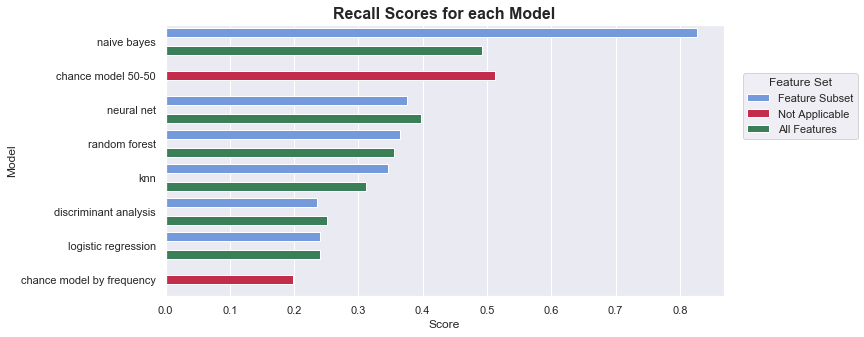

In [358]:
# Plot of recall scores
plt.figure(figsize=(10,5))
sb.barplot(data=recall_scores, y='Model', x='Score', hue='Feature_Set', palette=hue_pal)
plt.legend(bbox_to_anchor=(1.25, 0.70), title="Feature Set")
plt.title('Recall Scores for each Model', fontweight='bold', fontsize=16)
plt.show()

Only the 50-50 chance simulation had a higher recall scores than any model; however, this apparent success is illusory. Since such chance guessing assigns a 50% chance that each observation is yes/True for the target, and the relative frequency of yes/True is small in the dataset, it is bound to high comparatively high recall. However 50-50 chance guessing results in a poor accuracy as can be seen in the next plot. One might arguably desire higher recall scores for many of the models which might be addressed by oversampling techniques to increase the relative frequency in the target.

In terms of addressing the research question posed, we see that using the determined subset of features generally did not reduce recall. In fact, using the feature subset increased scores in half of the models used.

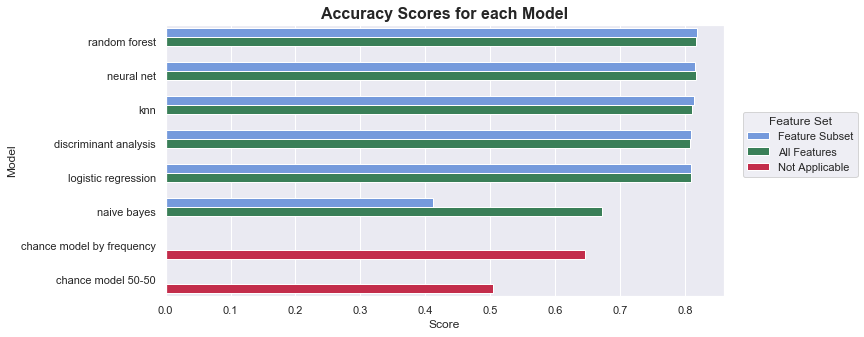

In [359]:
# Plot of accuracy scores
plt.figure(figsize=(10,5))
sb.barplot(data=accuracy_scores, y='Model', x='Score', hue='Feature_Set', palette=hue_pal)
plt.legend(bbox_to_anchor=(1.25, 0.70), title="Feature Set")
plt.title('Accuracy Scores for each Model', fontweight='bold', fontsize=16)
plt.show()

Whereas recall is a more complicated picture, the accuracy scores consistently (with the exception of Naive Bayes) show the built models outperforming guessing by chance. Regarding the research question, overall the models built on only the subset of the data appear to have a marginally higher accuracy (with the exception of Naive Bayes). Let's zoom in on those for comparison.

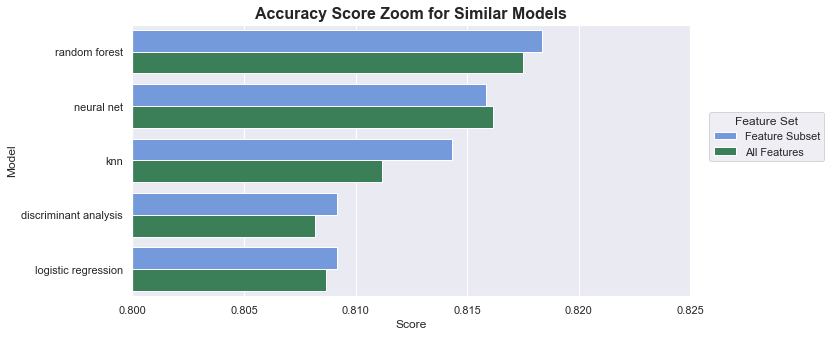

In [374]:
# Create a subset df only showing the scores that were close
accuracy_scores_sub = accuracy_scores.query('Model != "naive bayes" and Feature_Set != "Not Applicable"')

# Plot of accuracy scores
plt.figure(figsize=(10,5))
sb.barplot(data=accuracy_scores_sub, y='Model', x='Score', hue='Feature_Set', palette=hue_pal)
plt.legend(bbox_to_anchor=(1.25, 0.70), title="Feature Set")
plt.title('Accuracy Score Zoom for Similar Models', fontweight='bold', fontsize=16)
plt.xlim(0.8,0.825)
plt.show()

Indeed only the neural net benefitted (and only slightly so) from having access to the whole dataset.

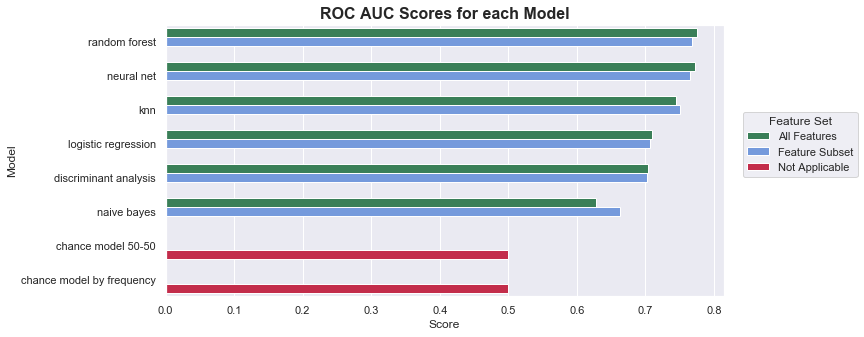

In [360]:
# Plot of ROC AUC scores
plt.figure(figsize=(10,5))
sb.barplot(data=roc_scores, y='Model', x='Score', hue='Feature_Set', palette=hue_pal)
plt.legend(bbox_to_anchor=(1.25, 0.70), title="Feature Set")
plt.title('ROC AUC Scores for each Model', fontweight='bold', fontsize=16)
plt.show()

Overall however, we should be most interested in the ROC AUC scores for each model as this metric represents a balance of the true positive rate and the false positive rate. Here all build models perform better than the chance baseline by a considerable margin. More interestingly, all models built on all just the feature subset have comparable scores to models that had access to the full dataset. In some cases, such as Naive Bayes and KNN, the models built on just the feature subset slightly outperformed models which used the overall dataset.

**While there may remain many opportunities to improve on each of the models built here, we can safely argue that the subset of features identified in this exercise provide comparable (and sometimes superior) models to those that have access to the whole dataset, and that each is better than chance guessing by a noteworthy margin.**

## References

Abu Alfeilat, H. A., Hassanat, A. B., Lasassmeh, O., Tarawneh, A. S., Alhasanat, M. B., Eyal Salman, H. S., & Prasath, V. S. (2019). Effects of Distance Measure Choice on K-Nearest Neighbor Classifier Performance: A Review. *Big data*.

Batista, G. E. A. P. A., & Silva, D. F. (2009). How k-nearest neighbor parameters affect its performance. In *Argentine symposium on artificial intelligence* (pp. 1-12). sn.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Hu, L. Y., Huang, M. W., Ke, S. W., & Tsai, C. F. (2016). The distance function effect on k-nearest neighbor classification for medical datasets. *SpringerPlus*, 5(1), 1304.

Ensemble methods — scikit-learn 0.22.1 documentation. (2020). Retrieved 18 January 2020, from https://scikit-learn.org/stable/modules/ensemble.html#parameters

Linear and Quadratic Discriminant Analysis — scikit-learn 0.22.1 documentation. (2020). Retrieved 19 January 2020, from https://scikit-learn.org/stable/modules/lda_qda.html

Linear Models — scikit-learn 0.22.1 documentation. (2020). Retrieved 19 January 2020, from https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Naive Bayes — scikit-learn 0.22.1 documentation. (2020). Retrieved 18 January 2020, from https://scikit-learn.org/stable/modules/naive_bayes.html

Neural network models (supervised) — scikit-learn 0.22.1 documentation. (2020). Retrieved 19 January 2020, from https://scikit-learn.org/stable/modules/neural_networks_supervised.html

Panchal, G., Ganatra, A., Kosta, Y. P., & Panchal, D. (2011). Behaviour analysis of multilayer perceptrons with multiple hidden neurons and hidden layers. *International Journal of Computer Theory and Engineering*, 3(2), 332-337.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Vanderplas, J. (2011). Scikit-learn: Machine learning in Python. *Journal of machine learning research, 12*(Oct), 2825-2830.

Probst, P., & Boulesteix, A. L. (2017). To Tune or Not to Tune the Number of Trees in Random Forest. *Journal of Machine Learning Research*, 18, 181-1.

Probst, P., Boulesteix, A. L., & Bischl, B. (2019). Tunability: Importance of Hyperparameters of Machine Learning Algorithms. Journal of Machine Learning Research, 20(53), 1-32.

Probst, P., Wright, M. N., & Boulesteix, A. L. (2019). Hyperparameters and tuning strategies for random forest. *Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery*, 9(3), e1301.

Scornet, E. (2017). Tuning parameters in random forests. *ESAIM: Proceedings and Surveys*, 60, 144-162.

Sklearn.ensemble.RandomForestClassifier — scikit-learn 0.22.1 documentation. (2020). Retrieved 18 January 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. *Expert Systems with Applications*, 36(2), 2473-2480.